In [1]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import numpy as np
import math
import sklearn
from gurobipy import *

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Haikun Huang, 391180

Ruixiang Wang, 400655

Read the provided data via `pandas/geopandas`.  
Remove duplicates (by column 'plz') from `zuordnung_plz_ort.csv`. Make sure that all data frames contain the same number of rows.  
Append the state names to both the 'shape' and 'centroid' data frames.  
Reference: [read_file](https://geopandas.org/reference/geopandas.read_file.html), [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [drop_duplicates](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html), [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html)

In [2]:
df_plz_ort = pd.read_csv('zuordnung_plz_ort.csv')
df_plz_ort = df_plz_ort.drop_duplicates(subset=['plz'])

df_shape = gpd.read_file('plz-5stellig.shp')
df_shape['plz'] = df_shape['plz'].astype(int)

df_centroid = gpd.read_file('plz-5stellig-centroid.shp')
df_centroid['plz'] = df_centroid['plz'].astype(int)

assert len(df_plz_ort) == len(df_shape) == len(df_centroid)

df_shape = df_shape.merge(df_plz_ort[['plz', 'bundesland']], on='plz', how='left')
df_centroid = df_centroid.merge(df_plz_ort[['plz', 'bundesland']], on='plz', how='left')

# df_shape

Create a contiguity graph $G$ as described on tutOR.

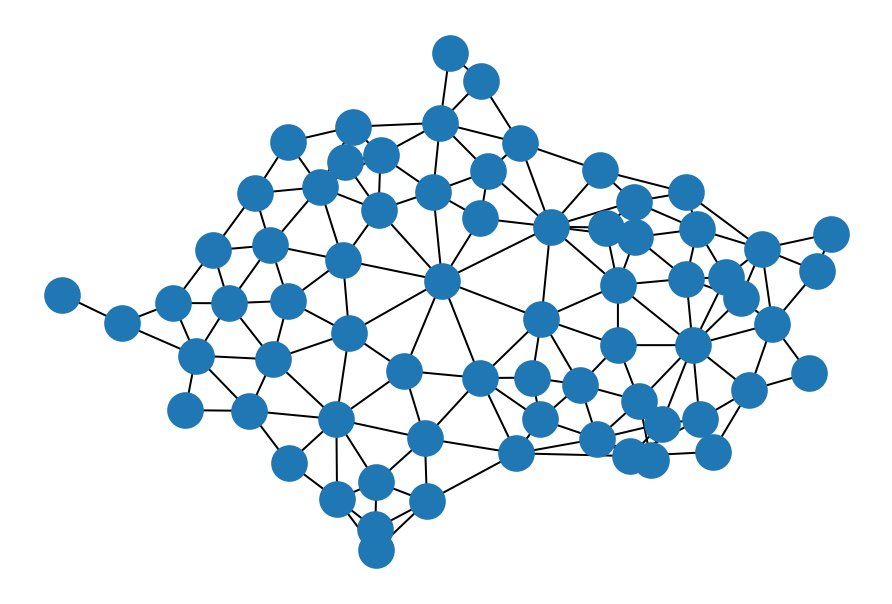

In [3]:
G = nx.Graph()

#add nodes
idx_list = []
for idx, row in df_shape.iterrows():
    if row['bundesland'] == 'Saarland':
        plz = int(row['plz'])
        num_person = int(row['einwohner'])
        G.add_node(plz, population=num_person)
        idx_list.append(idx)

# assert len(df_shape[df_shape['bundesland'] == 'Saarland']) == len(idx_list)

#add edges
edges = []
edge_tuples = []
for i in range(len(idx_list)):
    for j in range(i+1, len(idx_list)):
        idx1 = idx_list[i]
        idx2 = idx_list[j]
        if df_shape['geometry'][idx1].touches(df_shape['geometry'][idx2]):
            edges.append((int(df_shape['plz'][idx1]), int(df_shape['plz'][idx2])))
            # checking item in edge_tuples
            if (idx1, idx2) not in edge_tuples and (idx2, idx1) not in edge_tuples:
                edge_tuples.append((idx1, idx2))

G.add_edges_from(edges)

nx.draw(G)

# G.nodes(data=True)

Plot the map of Saarland. The following details need to be present in the picture:
* the borders of each postcode
* the centroids of each postcode
* the lines connecting the centroids of neighboring postcodes

Reference: [Mapping Tools](https://geopandas.org/mapping.html), [pyplot](https://matplotlib.org/tutorials/introductory/pyplot.html), [touches](https://geopandas.org/reference.html#geopandas.GeoSeries.touches)

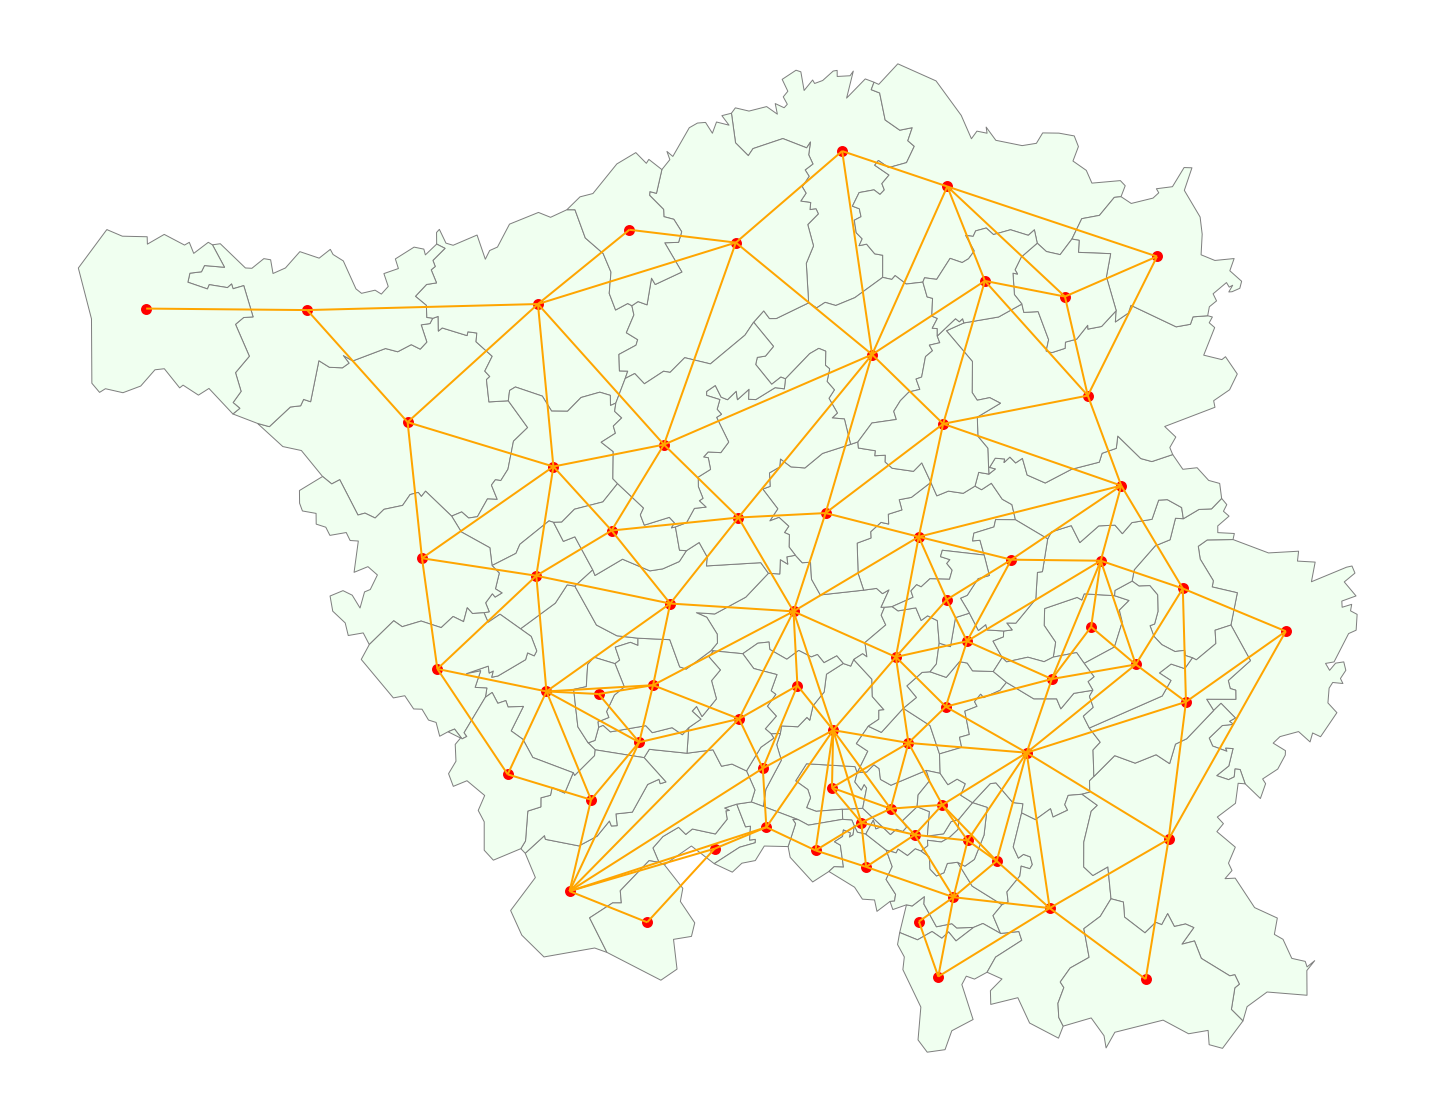

In [4]:
from shapely.geometry import Point, Polygon, LineString

df_shape_S = df_shape[df_shape['bundesland'] == 'Saarland']
df_centroid_S = df_centroid[df_centroid['bundesland'] == 'Saarland']

lines = []
for start, end in edge_tuples:
    p1 = df_centroid_S['geometry'][start][0]
    p2 = df_centroid_S['geometry'][end][0]
    lines.append(LineString([p1, p2]))

df_lines = gpd.GeoDataFrame(geometry=lines)

fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

df_lines.plot(ax=ax, color='orange', linewidth=1)
df_shape_S.plot(ax=ax, color='honeydew', edgecolor='gray', linewidth=0.5)
df_centroid_S.plot(ax=ax, marker='o', color='red', markersize=20)

ax.axis('off')
plt.show()

Model the problem.
Upload the model for the pricing problem and the function to create a shortest path tree to tutOR.

Split Saarland into 3 districts with the required district population being equal to 340000.

In [5]:
k = 3
req_p = 340000

Write a function that generates a feasible solution to begin with and return the according patterns. Visualize a feasible solution.

343978
299501
356967


(6.3053959850000005, 7.455965514999999, 49.08662667499999, 49.665662825000005)

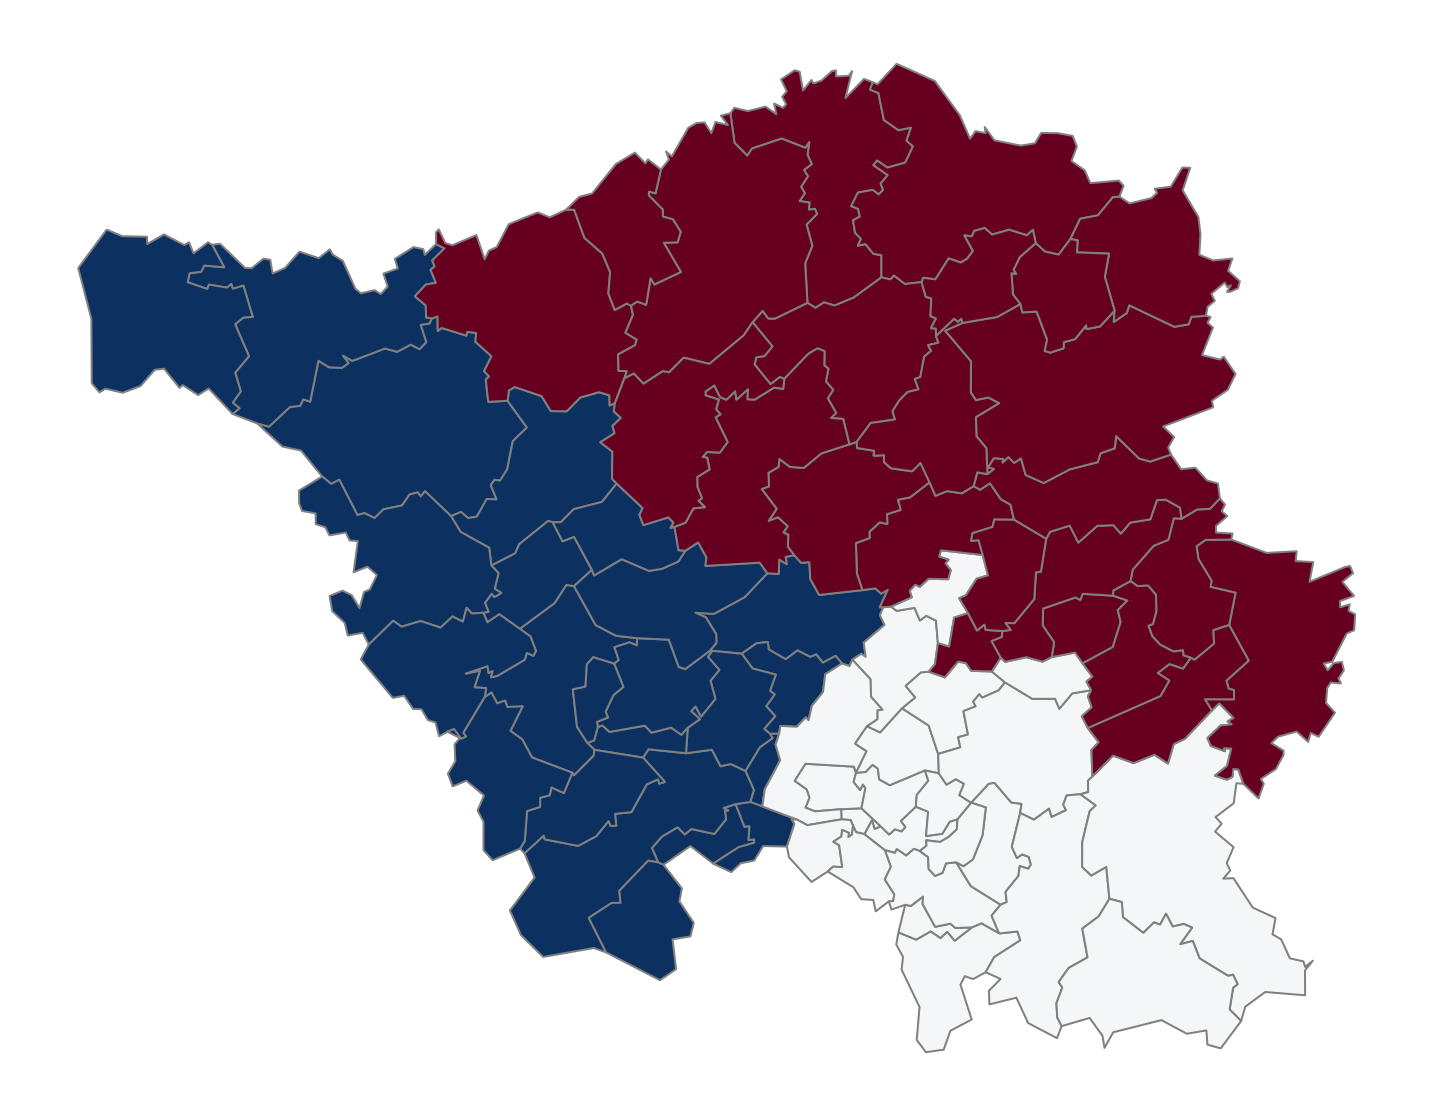

In [6]:
from sklearn.cluster import AgglomerativeClustering


def cal_sum(df_shape_S, label):
    df = df_shape_S[df_shape_S['init_label']==label]
    return sum(df['einwohner'])

def cluster(df_centroid_S, k, req_p, edge_tuples, df_shape_S):
    X = []
    m = len(df_centroid_S)

    for idx, row in df_centroid_S.iterrows():
        a = row['geometry'][0].x
        b = row['geometry'][0].y
        X.append([a,b])
    X = np.array(X)

    cls = AgglomerativeClustering(n_clusters = k)
    predicted_labels = cls.fit_predict(X)
    

    df_shape_S_label = df_shape_S.copy(deep=True)
    df_shape_S_label['init_label'] = predicted_labels

    # manipulate the result of clustering to make it statisities population restrict
    flag = False
    for idx2, row2 in df_shape_S_label[df_shape_S_label['init_label']==2].iterrows():
        for idx0,row0 in df_shape_S_label[df_shape_S_label['init_label']==0].iterrows():
            if row2['geometry'].touches(row0['geometry']):
                df_shape_S_label.loc[idx0, 'init_label'] = 2
                if cal_sum(df_shape_S_label, 0) < req_p:
                    flag = True
                    break
        if flag:
            break
                
    flag = False
    for idx2, row2 in df_shape_S_label[df_shape_S_label['init_label']==2].iterrows():
        for idx1, row1 in df_shape_S_label[df_shape_S_label['init_label']==1].iterrows():
            if row2['geometry'].touches(row1['geometry']):
                df_shape_S_label.loc[idx1,'init_label'] = 2
                if cal_sum(df_shape_S_label, 2) > req_p:
                    flag = True
                    break
        if flag:
            break

    flag = False
    for idx2, row2 in df_shape_S_label[df_shape_S_label['init_label']==2].iterrows():
        for idx1, row1 in df_shape_S_label[df_shape_S_label['init_label']==1].iterrows():
            if row2['geometry'].touches(row1['geometry']):
                df_shape_S_label.loc[idx1,'init_label'] = 2
                if cal_sum(df_shape_S_label, 2) > req_p:
                    flag = True
                    break
        if flag:
            break
    
    return df_shape_S_label

#edit df_centroid_S dataframe
df_shape_S_label = cluster(df_centroid_S, k, req_p, edge_tuples, df_shape_S)

#init 
#pattern is only for one district
def initialization(df_shape_S):
    patterns = []
    for i in range(k):
        patterns_item = {}
        for idx, row in df_shape_S.iterrows():
            if row['init_label'] == i:
                patterns_item[row['plz']] = 1
            else:
                patterns_item[row['plz']] = 0
        patterns.append(patterns_item)

    return patterns

patterns = initialization(df_shape_S_label)

# for i in range(k):
#     print(i,patterns[i])


df_label_0 = df_shape_S_label[df_shape_S_label['init_label']==0]
df_label_1 = df_shape_S_label[df_shape_S_label['init_label']==1]
df_label_2 = df_shape_S_label[df_shape_S_label['init_label']==2]

print(sum(df_label_0['einwohner']))
print(sum(df_label_1['einwohner']))
print(sum(df_label_2['einwohner']))

#visulization
ig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')
df_label_0.plot(edgecolor='0.5',facecolor="#0C3161",ax=ax)
df_label_1.plot(edgecolor='0.5',facecolor="#F4F6F8",ax=ax)
df_label_2.plot(edgecolor='0.5',facecolor="#670020",ax=ax)
ax.axis('off')

Write a function to construct the shortest path tree. Ignore this in the beginning and start implementing the restricted master problem and the pricing problem(s) first. Create the function, when you need it

In [7]:
# takes a graph G and a root node as input and returns a shortest path tree
def construct_spt(G, root):

    queue=[]
    queue.append(root)
    seen=[]
    seen.append(root)
    parent={root:None}

    while queue:
        vertex = queue.pop(0)
        nodes = [n for n in G.neighbors(vertex)]
        for w in nodes:
            if w not in seen:
                queue.append(w)
                seen.append(w)
                parent[w]=vertex
    
    spt = nx.create_empty_copy(G, with_data=True)

    for node in G.nodes():
        if node != root:
            shortest_path_list = []
            while node:
                shortest_path_list.append(node)
                node = parent[node]
            
            # reverse shortest_path_list
            # init list [terminal,c,b,a,root]
            # reversed list [root,a,b,c,terminal]
            reversed_shortest_path_list = list(reversed(shortest_path_list))

            # add edges
            for i in range(len(reversed_shortest_path_list)-1):
                spt.add_node(reversed_shortest_path_list[i], distance=i)
                spt.add_edge(reversed_shortest_path_list[i], reversed_shortest_path_list[i+1])
            spt.add_node(reversed_shortest_path_list[-1], distance=len(reversed_shortest_path_list)-1)

    return spt

Write a function that contains the pricing problem(s) and that returns the best patterns. Ignore this in the beginning and start implementing the restricted master problem first. Upload the pricing problem and the construct_spt(G, root) function in one file to tutOR

In [8]:
# the pi variables have to be indexed with the municipality ZIP-Codes, this is necessary for tutOR
# pi is a dict containing the dual variable for each constraint. The indices have to be the municipality ZIP-codes. There is one additional dual variable (which one?), it should have index 0
def solve_pricing_problem(G, req_p, pi: dict, u):
    
    # shortest-path-tree
    spt = construct_spt(G, u)

    plz_list = [m for m, _ in spt.nodes(data=True)]

    # build pricing problem
    pp = Model("political districting pricing problem")

    y={}
    for m in plz_list:
        y[m] = pp.addVar(name="y_%s" % (m), vtype=GRB.BINARY)


    # populations constrains req_p * 0.85 <= X <= req_p * 1.15
    pp.addConstr(quicksum(y[m] * spt.nodes[m]['population'] for m in plz_list) >= req_p * (1 - 0.15))
    pp.addConstr(quicksum(y[m] * spt.nodes[m]['population'] for m in plz_list) <= req_p * (1 + 0.15))

    # contiguity constrains using shortest-path-tree y0+..+ym >= ym * m
    for m in plz_list:
        path_list = nx.shortest_path(spt, source = m, target = u)
        pp.addConstr(quicksum(y[visit] for visit in path_list) >= y[m] * len(path_list))

    # solving Abs_value
    populations_deviation = pp.addVar(name="populations_deviation", vtype=GRB.INTEGER)
    pp.addConstr(populations_deviation >= quicksum(y[m] * spt.nodes[m]['population'] for m in plz_list) - req_p)
    pp.addConstr(populations_deviation >= req_p - quicksum(y[m] * spt.nodes[m]['population'] for m in plz_list))

    # pricing problem's objective
    pp.setObjective(
        quicksum(y[m] * spt.nodes[m]['distance'] for m in plz_list) + 
        populations_deviation - 
        quicksum(y[m] * pi[m] for m in plz_list) -
        pi[0], 
        GRB.MINIMIZE
    )

    # gurobi should be silent
    pp.params.outputFlag = 0

    pp.update()
    pp.optimize()
    
    return pp

In [9]:
def solve(G, k, req_p, patterns):

    first_pattern = None

    patterns_populations_deviation = {}

    plz_list = [m for m, _ in G.nodes(data=True)]

    # build the initial restricted master problem (RMP)
    rmp = Model("political districting RMP")

    lambdas={}
    for p in range(len(patterns)):
        lambdas[p] = rmp.addVar(name=f'lambdas_{p}', vtype = GRB.CONTINUOUS)

    demand={}
    for m in plz_list:
        demand[m] = rmp.addConstr(quicksum(patterns[p][m] * lambdas[p] 
                                    for p in range(len(patterns))) == 1, 
                                    name = "demand_%s" % (p))

    req_k = rmp.addConstr(quicksum(lambdas[p] for p in range(len(patterns))) == 3)

    for p in range(len(patterns)):
        rmp.addConstr(lambdas[p] <= 1)

    for p in range(len(patterns)):
        populations_count = 0
        for m in plz_list:
            if patterns[p][m] == 1:
                populations_count = populations_count + int(G.nodes[m]['population'])
        patterns_populations_deviation[p] = abs(populations_count - req_p)

    rmp.setObjective(
        quicksum(patterns_populations_deviation[p] * lambdas[p] for p in range(len(patterns))), 
        GRB.MINIMIZE
    )

    ############################################################################################
    
    # column generation loop
    for iteration in range(2):

        rmp.optimize()

        pi={}
        pi[0] = req_k.getAttr(GRB.Attr.Pi)
        for m in plz_list:
            pi[m] = demand[m].getAttr(GRB.Attr.Pi)
        print('pi_0: ',pi[0])

        mini_value = float('inf')
        mini_root = None

        for m in plz_list:
            pp = solve_pricing_problem(G, req_p, pi, m)
            if pp.objVal < mini_value:
                mini_value = pp.objVal
                mini_root = m

        pp = solve_pricing_problem(G, req_p, pi, mini_root)
        
        #####################################################################
        
        # getting all mini_distance from pp model
        spt_temp = construct_spt(G, mini_root)
        y_temp = dict()
        for m in plz_list:
            name = 'y_'+ str(m)
            y_temp[m] = pp.getVarByName(name)
            
        mini_distance = 0
        for m in plz_list:
            mini_distance = mini_distance + y_temp[m].x * spt_temp.nodes[m]['distance']
        print('mini_distance: ', mini_distance)
        #####################################################################
        
        print('mini_value',mini_value)
        if mini_value - mini_distance < -.00001:

            #pattern update
            new_pattern = {}
            y = dict()
            for m in plz_list:
                name = 'y_'+ str(m)
                y[m] = pp.getVarByName(name)
                if y[m].x > 0.1: # sparsely store the pattern, only positive entries
                    new_pattern[m] = y[m].x
                else:
                    new_pattern[m] = 0
            patterns.append(new_pattern)

            if first_pattern == None:
                first_pattern = new_pattern

            p = len(patterns) - 1
            lambdas[p] = rmp.addVar(name=f'lambdas_{p}',
                                    column = Column(list(int(y[m].x) for m in plz_list), list(demand[m] for m in plz_list)))
                
            populations_count = 0
            for m in plz_list:
                if patterns[p][m] == 1:
                    populations_count = populations_count + int(G.nodes[m]['population'])
            patterns_populations_deviation[p] = abs(populations_count - req_p)
            
            rmp.setObjective(
                quicksum(patterns_populations_deviation[p] * lambdas[p] for p in range(len(patterns))), 
                GRB.MINIMIZE
            )

        else:
            print('optimal')
            break

    rmp.optimize()

    return rmp, patterns, first_pattern


In [10]:
model, patterns, first_pattern = solve(G, k, req_p, patterns)

Academic license - for non-commercial use only - expires 2021-09-11
Using license file /Users/wujingning/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 73 rows, 3 columns and 75 nonzeros
Model fingerprint: 0xcb6b084e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+03, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 73 rows and 3 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1444000e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  6.144400000e+04
pi_0:  0.0
mini_distance:  27.0
mini_value -61416.0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model wit

In [11]:
lambdas = dict()
for p in range(len(patterns)):
    name = 'lambdas_'+ str(p)
    lambdas[p] = model.getVarByName(name)
    print(p,lambdas[p])

0 <gurobi.Var lambdas_0 (value 1.0)>
1 <gurobi.Var lambdas_1 (value 1.0)>
2 <gurobi.Var lambdas_2 (value 1.0)>
3 <gurobi.Var lambdas_3 (value 0.0)>
4 <gurobi.Var lambdas_4 (value 0.0)>


Visualize the first pattern created. Plot the map of Saarland in the background and a graph which displays the pattern in the foreground

(6.3053959850000005, 7.455965515000001, 49.086626675, 49.665662825)

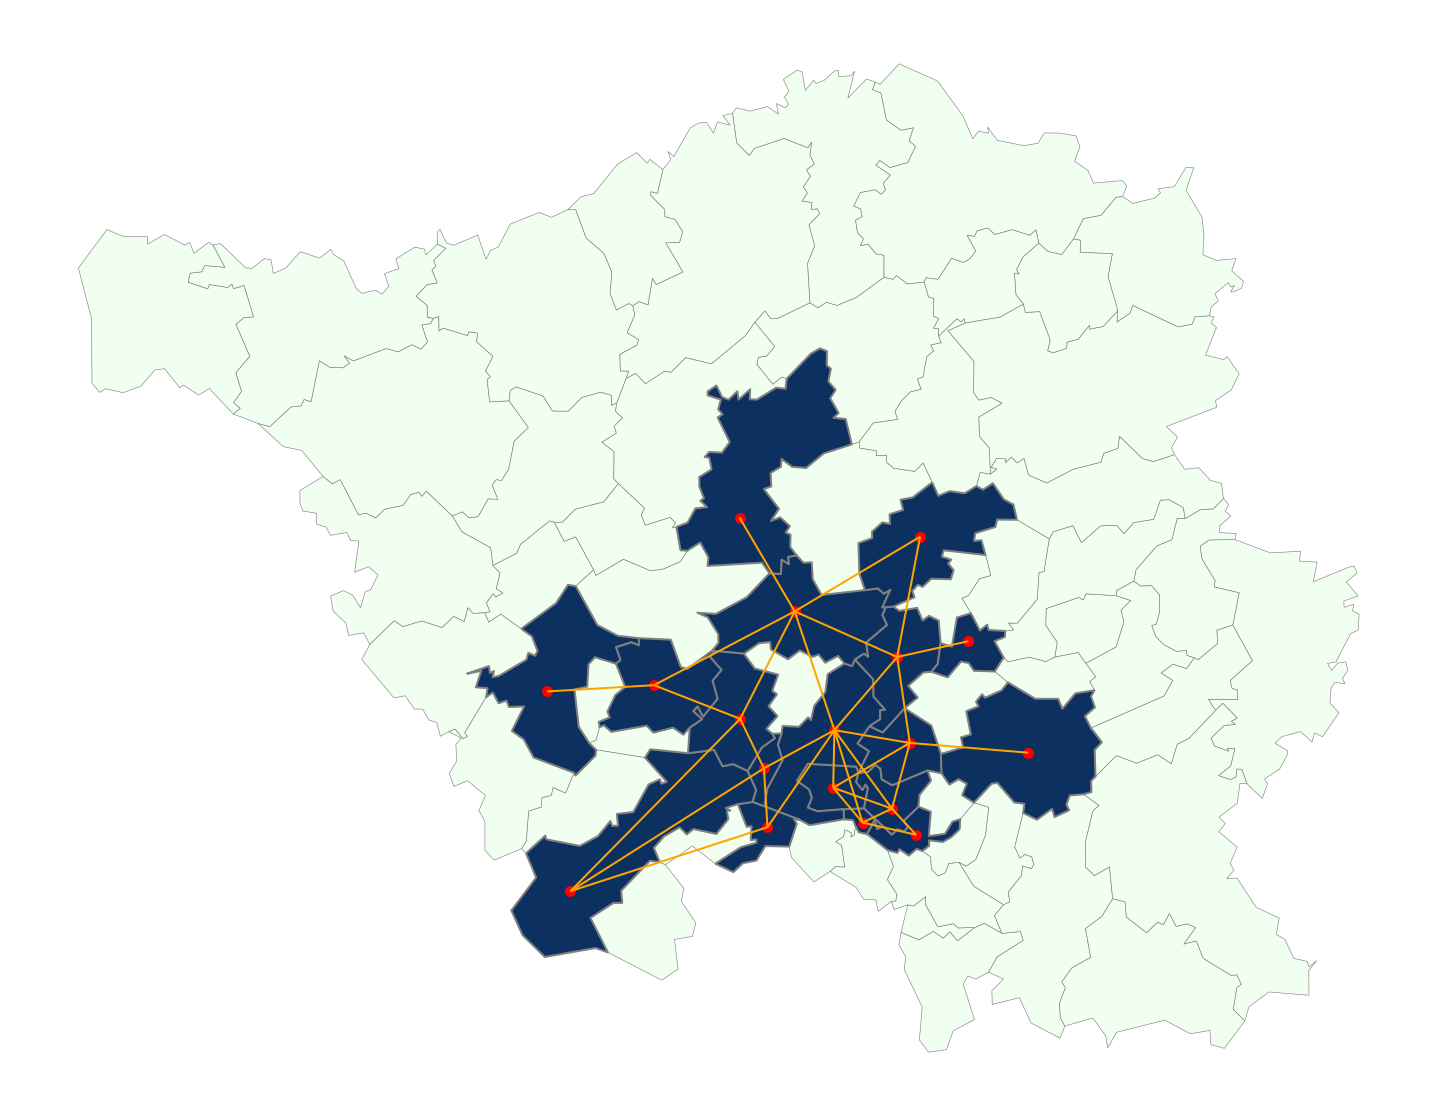

In [12]:
from shapely.geometry import Point, Polygon, LineString

df_centroid_S_label = df_centroid_S.copy(deep=True)

df_shape_S_label['init_label'] = first_pattern.values()
df_centroid_S_label['init_label'] = first_pattern.values()

df_temp = df_shape_S_label[df_shape_S_label['init_label'] == 1]
df_res = df_shape_S_label[df_shape_S_label['init_label'] == 0]
df_temp_centroid = df_centroid_S_label[df_centroid_S_label['init_label'] == 1]


#add nodes
idx_list_show = []
for idx, row in df_temp.iterrows():
        idx_list_show.append(idx)

#add edges
edge_tuples_show = []
for i in range(len(idx_list_show)):
    for j in range(i+1, len(idx_list_show)):
        idx1 = idx_list_show[i]
        idx2 = idx_list_show[j]
        if df_temp['geometry'][idx1].touches(df_temp['geometry'][idx2]):
            if (idx1, idx2) not in edge_tuples_show and (idx2, idx1) not in edge_tuples_show:
                edge_tuples_show.append((idx1, idx2))

lines = []
for start, end in edge_tuples_show:
    p1 = df_temp_centroid['geometry'][start][0]
    p2 = df_temp_centroid['geometry'][end][0]
    lines.append(LineString([p1, p2]))
df_lines = gpd.GeoDataFrame(geometry=lines)


ig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')
df_lines.plot(ax=ax, color='orange', linewidth=1)
df_shape_S.plot(ax=ax, color='honeydew', edgecolor='gray', linewidth=0.3)
df_temp.plot(edgecolor='0.5',facecolor="#0C3161",ax=ax)
df_temp_centroid.plot(ax=ax, marker='o', color='red', markersize=20)
ax.axis('off')

Use the `Gurobi` solution to plot the map of Saarland with each district colored in different color.

(6.3053959850000005, 7.455965514999999, 49.08662667499999, 49.665662825000005)

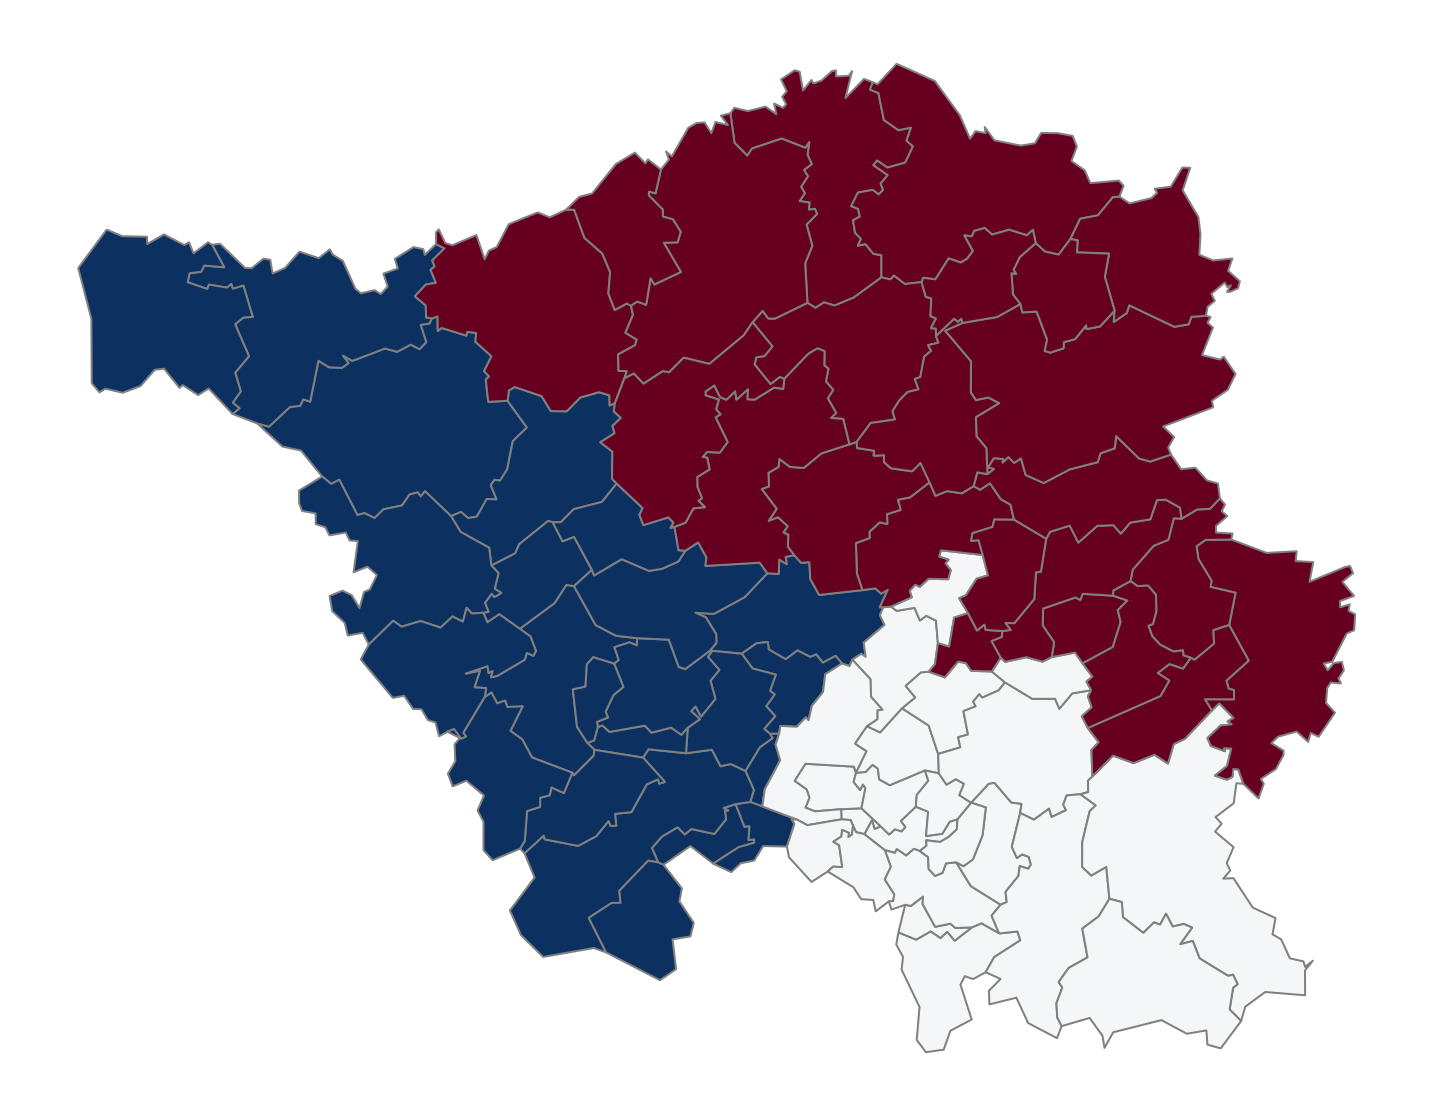

In [13]:
plz_list = [m for m, _ in G.nodes(data=True)]

lambdas = dict()
for p in range(len(patterns)):
    name = 'lambdas_'+ str(p)
    lambdas[p] = model.getVarByName(name)
    
count_k = 0
for p in range(len(patterns)):
    if lambdas[p].x == 1:
        for m in G.nodes():
            if patterns[p][m] == 1:
                idx = df_shape_S_label[df_shape_S_label['plz'] == m].index
                df_shape_S_label.loc[idx, 'init_label'] = count_k
        count_k = count_k + 1

df_label = list()
for i in range(k):
    df_label.append(df_shape_S_label[df_shape_S_label['init_label'] == i])
    
#visulization
ig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')
color = ['#0C3161', '#F4F6F8', '#670020']
for i in range(k):
    df_label[i].plot(edgecolor='0.5',facecolor = color[i],ax = ax)
ax.axis('off')

For each district:
* check whether the population constraint was satisfied (print the district's population)
* print the names of towns and villages assigned to it

Reference: [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html)

In [14]:
for i in range(k):
    print('District ',i)
    print('Population:',req_p * (1-0.15), '<=',sum(df_label[i]['einwohner']),'<=',req_p * (1+0.15))
    print('Count of Towns and villages:',len(df_label[i]))
    print('Towns and villages:')
    print(df_label[i]['note'].values.tolist())
    print()

District  0
Population: 289000.0 <= 343978 <= 390999.99999999994
Count of Towns and villages: 23
Towns and villages:
['66126 SaarbrÃ¼cken', '66127 SaarbrÃ¼cken', '66128 SaarbrÃ¼cken', '66265 Heusweiler', '66292 Riegelsberg', '66333 VÃ¶lklingen', '66346 PÃ¼ttlingen', '66352 GroÃ\x9frosseln', '66359 Bous', '66663 Merzig', '66693 Mettlach', '66701 Beckingen', '66706 Perl', '66740 Saarlouis', '66763 Dillingen/Saar', '66773 Schwalbach', '66780 Rehlingen-Siersburg', '66787 Wadgassen', '66793 Saarwellingen', '66798 Wallerfangen', '66802 Ã\x9cberherrn', '66806 Ensdorf', '66809 Nalbach']

District  1
Population: 289000.0 <= 299501 <= 390999.99999999994
Count of Towns and villages: 22
Towns and villages:
['66111 SaarbrÃ¼cken', '66113 SaarbrÃ¼cken', '66115 SaarbrÃ¼cken', '66117 SaarbrÃ¼cken', '66119 SaarbrÃ¼cken', '66121 SaarbrÃ¼cken', '66123 SaarbrÃ¼cken', '66125 SaarbrÃ¼cken', '66129 SaarbrÃ¼cken', '66130 SaarbrÃ¼cken', '66131 SaarbrÃ¼cken', '66132 SaarbrÃ¼cken', '66133 SaarbrÃ¼cken', '66271 Kl